# 美国King County房价预测训练赛 

数据来自DC竞赛，训练集包括10000个样本，14个特征，测试集包括13个特征。<br>
特征说明：
<br>第一列“销售日期”：2014年5月到2015年5月房屋出售时的日期
<br>第二列“销售价格”：房屋交易价格，单位为美元，是目标预测值
<br>第三列“卧室数”：房屋中的卧室数目
<br>第四列“浴室数”：房屋中的浴室数目
<br>第五列“房屋面积”：房屋里的生活面积
<br>第六列“停车面积”：停车坪的面积
<br>第七列“楼层数”：房屋的楼层数
<br>第八列“房屋评分”：King County房屋评分系统对房屋的总体评分
<br>第九列“建筑面积”：除了地下室之外的房屋建筑面积
<br>第十列“地下室面积”：地下室的面积
<br>第十一列“建筑年份”：房屋建成的年份
<br>第十二列“修复年份”：房屋上次修复的年份
<br>第十三列"纬度"：房屋所在纬度
<br>第十四列“经度”：房屋所在经度

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
columns = ['date',
'price',
'bedroom',
'bathroom',
'roomarea',
'parkarea',
'floornum',
'score',
'buildingarea',
'baseroomarea',
'buildingdate',
'fixdate',
'lat',
'long']
train = pd.read_csv('../dataset/kc_train.csv', header=None, names=columns)

In [6]:
train.apply(lambda x: x.dtype)

date            float64
price           float64
bedroom         float64
bathroom        float64
roomarea        float64
parkarea        float64
floornum        float64
score           float64
buildingarea    float64
baseroomarea    float64
buildingdate    float64
fixdate         float64
lat             float64
long            float64
dtype: object

In [2]:
# 目标变量
target_var = 'price'

# 数值变量
num_col = ['bedroom','bathroom','roomarea','parkarea','score','buildingarea','baseroomarea']

# 日期
date_col = ['date','buildingdate','fixdate']

# 经纬度
loc_col = ['lat','long']

In [5]:
train.describe()

,date,price,bedroom,bathroom,roomarea,parkarea,floornum,score,buildingarea,baseroomarea,buildingdate,fixdate,lat,long
count,1.000000e+04,1.000000e+04,10000.000000,10000.0000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.014392e+07,5.428749e+05,3.367600,2.1168,2082.488400,1.535273e+04,1.502850,7.664800,1791.474900,291.013500,1971.204700,85.209700,47.560629,-122.215845
std,4.440706e+03,3.729258e+05,0.893169,0.7741,922.878916,4.577623e+04,0.543642,1.173873,829.449437,446.641339,29.322957,403.491421,0.138570,0.139739
min,2.014050e+07,7.500000e+04,0.000000,0.0000,390.000000,5.720000e+02,1.000000,3.000000,390.000000,0.000000,1900.000000,0.000000,47.159300,-122.519000
25%,2.014072e+07,3.225000e+05,3.000000,1.7500,1430.000000,5.023250e+03,1.000000,7.000000,1190.000000,0.000000,1951.750000,0.000000,47.471375,-122.329000
50%,2.014102e+07,4.507000e+05,3.000000,2.2500,1910.000000,7.590000e+03,1.500000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.572200,-122.234000
75%,2.015022e+07,6.450000e+05,4.000000,2.5000,2550.000000,1.071700e+04,2.000000,8.000000,2211.500000,560.000000,1997.000000,0.000000,47.678400,-122.127000
max,2.015053e+07,6.885000e+06,10.000000,7.7500,9890.000000,1.651359e+06,3.500000,13.000000,8860.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000


14个特征中，全部是数字变量。其中可以分为六类:
1. 日期，包括销售日期，建造日期，修复日期；
2. 房间数量
3. 楼层。不同楼层的房子，价格肯定是不一样，楼层似乎可以作为一个分类变量处理。
4. 评分
5. 面积
7. 经纬度。经纬度划分了房子的区域，单独使用经纬度的意义不大，可以通过聚类划分区域，成为分类变量。

## 房价分析

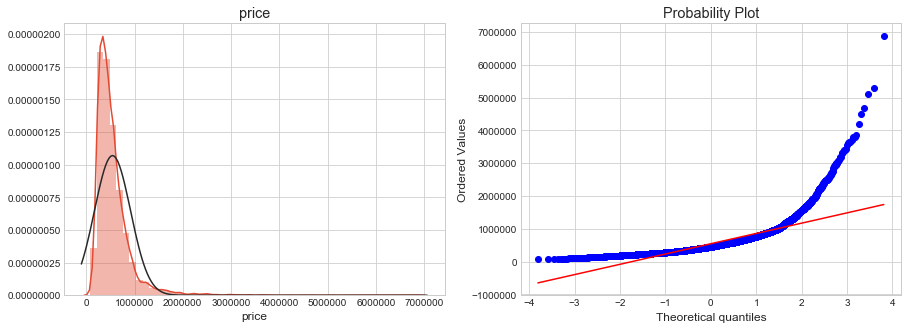

In [9]:
from scipy.stats import norm
fig = plt.figure(figsize=(15,5))
_ = plt.subplot(121)
sns.distplot(train['price'], fit=norm)
plt.title('price')
_ = plt.subplot(122)
res = stats.probplot((train['price']), plot=plt)

房价明显呈长尾分布，后期需要对价格进行对数预算，使它呈正态分布。从图中还可以看出，在房价上，存在明显的离群点。

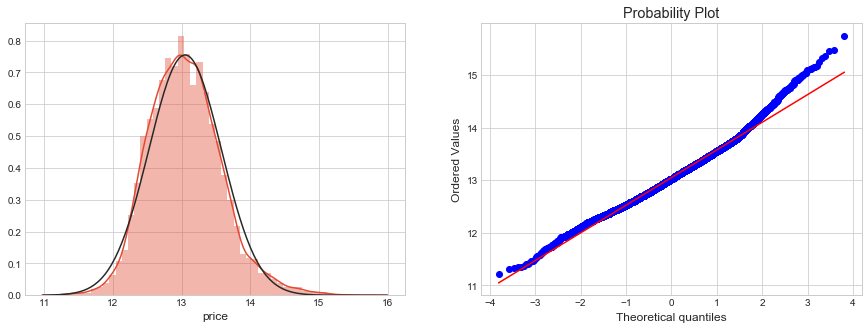

In [10]:
fig = plt.figure(figsize=(15,5))
_ = plt.subplot(121)
sns.distplot(np.log(train['price']), fit=norm)
_ = plt.subplot(122)
res = stats.probplot(np.log(train['price']), plot=plt)

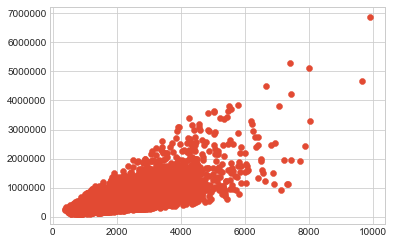

In [11]:
plt.scatter(train['roomarea'], train['price'])

### 日期处理

In [9]:
train['date'] = pd.to_datetime(train['date'], format='%Y%m%d')
train['y_sales'] = train['date'].map(lambda x: str(x)[:4])
train['m_sales'] = train['date'].map(lambda x: str(x)[5:7])

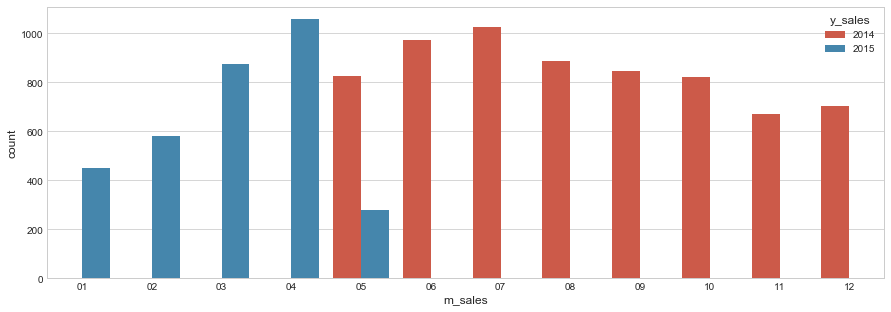

In [10]:
fig = plt.figure(figsize=(15,5))
sns.countplot(x='m_sales', data=train, hue='y_sales')

In [13]:
y2015_prices = train[train['y_sales'] == '2015']
y2014_prices = train[train['y_sales'] == '2014']

,price,bedroom,bathroom,roomarea,parkarea,floornum,score,buildingarea,baseroomarea,buildingdate,fixdate,lat,long
count,3.243000e+03,3243.000000,3243.000000,3243.000000,3.243000e+03,3243.000000,3243.000000,3243.000000,3243.000000,3243.000000,3243.000000,3243.000000,3243.000000
mean,5.463597e+05,3.349676,2.085338,2035.830712,1.688038e+04,1.487203,7.623805,1761.053962,274.776750,1971.499846,70.729571,47.554879,-122.215902
std,3.790331e+05,0.891987,0.776684,915.983252,6.103300e+04,0.550844,1.172774,824.301089,431.919706,28.987227,368.949293,0.141340,0.139474
min,7.500000e+04,0.000000,0.000000,390.000000,5.720000e+02,1.000000,3.000000,390.000000,0.000000,1900.000000,0.000000,47.177600,-122.511000
25%,3.230000e+05,3.000000,1.500000,1380.000000,5.100000e+03,1.000000,7.000000,1180.000000,0.000000,1952.000000,0.000000,47.456500,-122.331000
50%,4.500000e+05,3.000000,2.250000,1850.000000,7.620000e+03,1.000000,7.000000,1530.000000,0.000000,1974.000000,0.000000,47.565000,-122.229000
75%,6.450000e+05,4.000000,2.500000,2480.000000,1.069950e+04,2.000000,8.000000,2170.000000,500.000000,1998.000000,0.000000,47.676750,-122.126000
max,5.300000e+06,7.000000,6.000000,7880.000000,1.651359e+06,3.500000,13.000000,7880.000000,2390.000000,2015.000000,2015.000000,47.777600,-121.315000


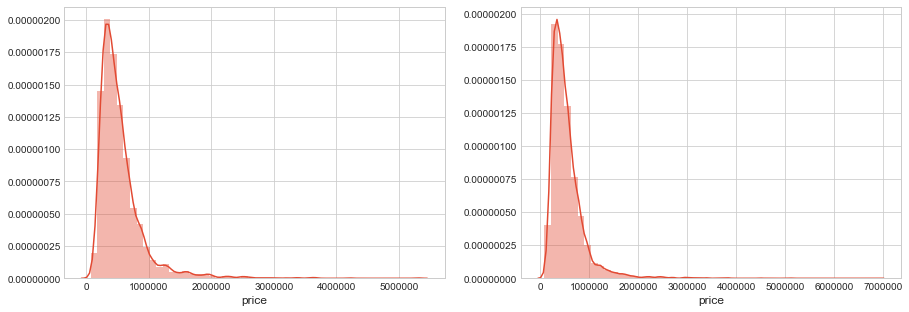

In [14]:
fig = plt.figure(figsize=(15,5))
_ = plt.subplot(121)
sns.distplot(y2015_prices['price'])
_ = plt.subplot(122)
sns.distplot(y2014_prices['price'])

2014年和2015年的房子销售价格没有明显的区别。

### 位置与房价的关系
经纬度反应了待售房子所处的位置。在我们通常的认识中，房子所在区域是影响房价的重要因素。

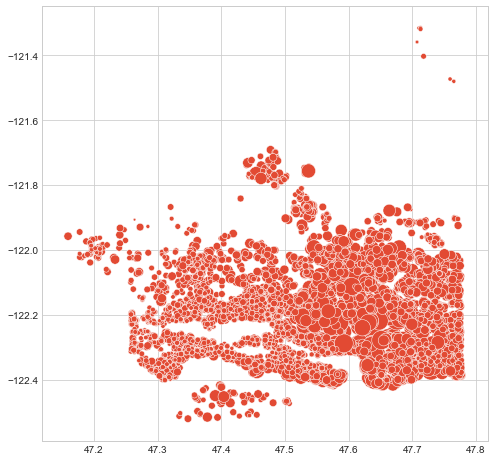

In [15]:
fig = plt.figure(figsize=(8,8))
plt.scatter(train['lat'], train['long'], edgecolors='white', s=train['price']/10000)

从上面房子的位置图可以看出，中间区域的房价明显高于其他区域，特别是处于地图边缘区域的房价。<br>
虽然房价和位置有关系，但是我们不能判断这是唯一的关系。毕竟房屋的类型，比如住宅和写字楼的价格是不一样的。

从上面的聚类结果和下面的箱形图来看，房屋的大致可以分为两类，南区和北区。

### 卧室和浴室数量

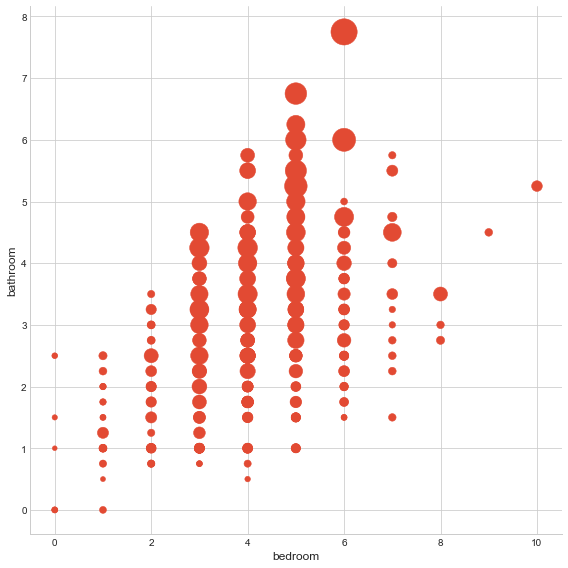

In [23]:
facet = sns.FacetGrid(train, size=8)
facet.map(plt.scatter, 'bedroom', 'bathroom', s=train['price']/10000)

### 房屋面积和停车面积

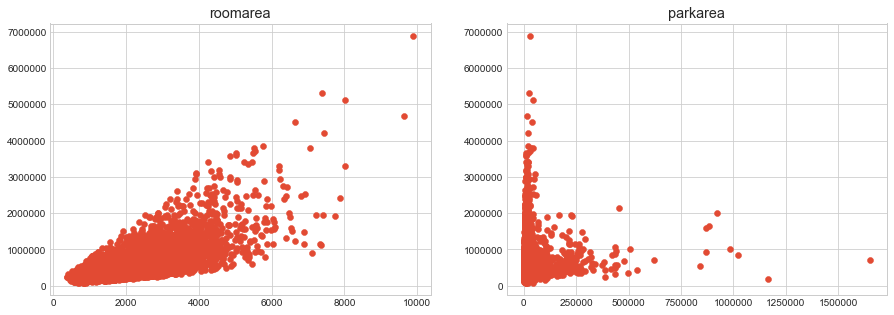

In [16]:
fig = plt.figure(figsize=(15,5))
_ = plt.subplot(121)
plt.scatter(train['roomarea'], train['price'])
plt.title('roomarea')
_ = plt.subplot(122)
plt.scatter(train['parkarea'], train['price'])
_ = plt.title('parkarea')

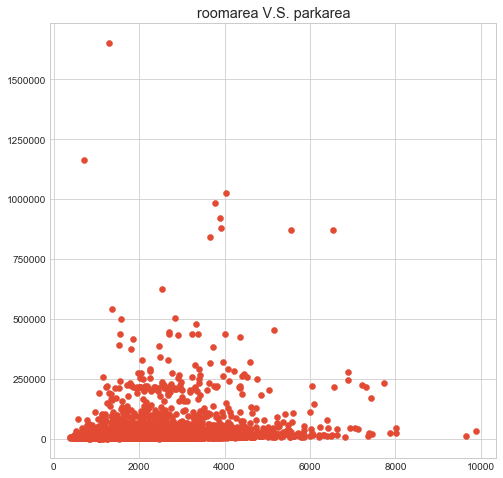

In [17]:
fig = plt.figure(figsize=(8,8))
_ = plt.scatter(train['roomarea'], train['parkarea'])
_ = plt.title('roomarea V.S. parkarea')

从上面的图可以看出，房屋面积和价格呈比较明显的线性关系，但是停车面积和房屋价格的关系不明显。需要注意的是，当停车面积为0时， 房屋价格也呈现比较广泛的分布。<br>
另外，需要注意，房屋面积和停车坪面积很可能不是同一个单位，因为从图上看，停车面积明显比房屋面积大一个数量级，后期需要将两个特征进行标准化。

### 翻新时间


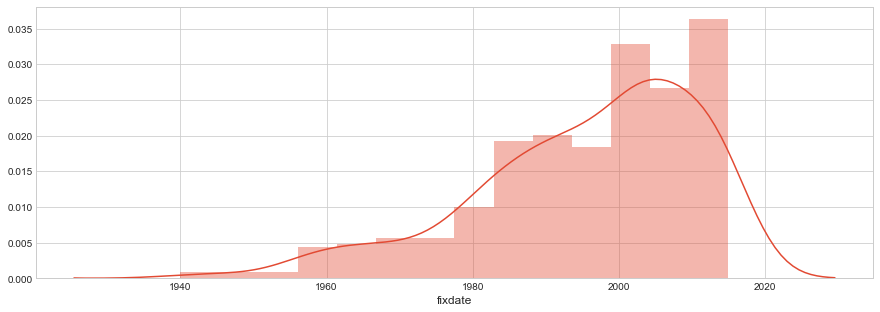

In [19]:
fixdate = train[train['fixdate'] > 0]
fig = plt.figure(figsize=(15,5))
_ = sns.distplot(fixdate['fixdate'])

大部分的房子是在2000以后翻新。

### 地下室

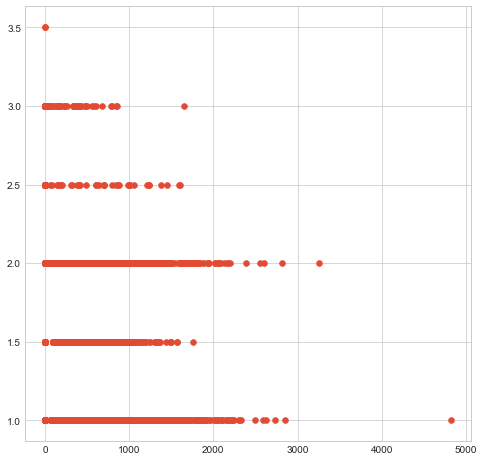

In [20]:
fig = plt.figure(figsize=(8,8))
plt.scatter(train['baseroomarea'], train['floornum'])

In [ ]:
fig = plt.figure(figsize=(15,5))
_ = sns.distplot(df_train['baseroomarea'])

大部分的房子是没有地下室的

### 建造时间

In [ ]:
fig = plt.figure(figsize=(15,5))
_ = sns.distplot(df_train['buildingdate'])

In [ ]:
fig = plt.figure(figsize=(15,5))
_ = sns.boxplot(y='price', x='score', data=df_train)

In [ ]:
fig = plt.figure(figsize=(15,5))
_ = sns.boxplot(y='price', x='bedroom', data=df_train)

In [ ]:
plt.figure(figsize=(20,7))
_ = sns.boxplot(y='price', x='buildingdate', data=df_train)

In [ ]:
plt.figure(figsize=(20,7))
_ = sns.boxplot(y='price', x='fixdate', data=df_train[df_train['fixdate']>0])

In [ ]:
plt.figure(figsize=(15,5))
_ = sns.countplot(x='score', data=df_train)

In [ ]:
plt.figure(figsize=(15,5))
_ = sns.boxplot(y='price', x='floornum', data=df_train)

In [ ]:
plt.figure(figsize=(20,20))
_ = sns.heatmap(df_train.corr(), annot=True)

从相关系数上看：
1. price和房屋面积，评分，建筑面积有很高的相关性
2. 评分和建筑面积有很强的相关性
3. 房屋面积和建筑面积有很强的相关性
从上面分析可以推测，房屋的价格与评分和面积的比较强的正相关性

对房屋价格进行对数变换

In [ ]:
fig = plt.figure(figsize=(15,5))
_ = plt.subplot(121)
sns.distplot(np.log(df_train['price']))
_ = plt.subplot(122)
res = stats.probplot((np.log(df_train['price'])), plot=plt)

经过对数变换后，价格明显呈正态分布。

In [ ]:
apartments = df_train[(df_train['bedroom'] == 0) & (df_train['bathroom'] == 0)]
apartments

## 建立基础模型

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [ ]:
df_train.head()

In [ ]:
feature_raw = df_train.copy()
feature_raw.drop(['price'], axis=1, inplace=True)
feature_raw.drop(['date'], axis=1, inplace=True)
#feature_raw.drop(['lat'], axis=1, inplace=True)
#feature_raw.drop(['long'], axis=1, inplace=True)

In [ ]:
feature_raw.head()

In [ ]:
cols = feature_raw.columns.tolist()

In [ ]:
feature_raw = pd.DataFrame(feature_raw, columns=cols)

In [ ]:
feature_raw['y_sales'] = feature_raw['y_sales'].astype(int)
feature_raw['m_sales'] = feature_raw['m_sales'].astype(int)

In [ ]:
scaler = StandardScaler()
feature_raw = scaler.fit_transform(feature_raw)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    feature_raw, df_train['price'], test_size=0.3, random_state=45)

kfold = StratifiedKFold(n_splits=45, random_state=45)

scorer = make_scorer(mean_squared_error)



In [ ]:
model = []
model.append(('linear', LinearRegression()))
model.append(('lasso', Lasso(random_state=45)))
model.append(('ridge', Ridge(random_state=45)))

for name, reg in model:
    cv = cross_val_score(estimator=reg, X=X_train, y=y_train, cv=kfold, scoring='r2')
    print('\nmodel report----{}:'.format(name))
    print('cv-mean: {0:.4f}, cv-std: {0:.4f}'.format(cv.mean(), cv.std()))

In [ ]:
import xgboost as xgb
gbm = xgb.XGBRegressor(n_estimators=2000, seed=42)
cv = cross_val_score(gbm, X_train, y_train, cv=10, scoring='r2')

In [ ]:
cv.mean()